In [1]:
from funcs_for_huff_notebook import *

I'm importing a few functions that help me show what's going on. These are the functions:
1. countChars: This counts each character in a string and creates a dictionary storing the counts.
2. display_tree: This displays a binary tree.
3. display_decode: This shows the process of decoding a Huffman coded string.

# Huffman coding

Huffman coding is an algorithm for encoding a string. It is the most efficient method that encodes each symbol separately. It creates a binary tree that encodes each character as a binary string.

To get started, type some words below:

In [2]:
some_string = input('Type some words: ')

Type some words:  These are some words.


Currently, this string is encoded in ascii. This means that each character is written using 1 byte, which is 8 bits. Therefore the number of bits used to encode this string is:

In [3]:
len(some_string) * 8

168

With Huffman coding, we can create a binary string that encodes this string in fewer bits.

The first step to encoding this string is to count how many times each character appears in it.

In [4]:
count_dict = countChars(some_string)

count_dict

{'T': 1,
 'h': 1,
 'e': 4,
 's': 3,
 ' ': 3,
 'a': 1,
 'r': 2,
 'o': 2,
 'm': 1,
 'w': 1,
 'd': 1,
 '.': 1}

Using this count, we create a very specific binary tree. I'll be storing the tree using a list of tuples. Each tuple will correspond to a node, and will have four values: a string as a key, the total number of times a character in the key appears in the input string, and the position of the left child in the list. Because of how we build our tree, every parent node has a left and a right child, and the position of the right child is always one more than the position of the left child.

The first nodes we put in our tree are the characters. I add them sorted by frequency, because this makes other steps in the algorithm easier.

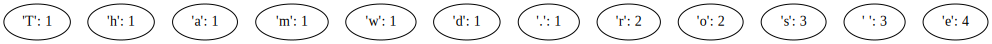

In [5]:
sorted_KV_pairs = sorted(count_dict.items(), key=lambda x:x[1])
huff_tree = [(key, value, None) for key, value in sorted_KV_pairs]

display_tree(huff_tree)

Our "tree" isn't much to look at right now, but we'll fix that.

Now, we create a new node that is the parent of the two nodes with lowest values. The key to this node contains both keys of the child nodes, so the total number of times a character from this key shows up in the input string is the sum of the times each character from the child nodes shows up.

In [6]:
lowest_node, second_lowest_node = huff_tree[0:2]
rarest_character, rarest_appearances  = lowest_node[0:2]
second_rarest_character, second_rarest_appearances = second_lowest_node[0:2]
new_node = (rarest_character + second_rarest_character, rarest_appearances + second_rarest_appearances, 0)

We insert this node in a way that keeps the nodes sorted by frequency in the list.

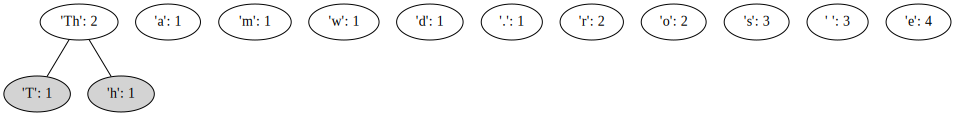

In [7]:
j = 2
while j < len(huff_tree) and huff_tree[j][1] < new_node[1]:
    j += 1
huff_tree.insert(j, new_node)

display_tree(huff_tree, showchange=True)

Now we have a sort of mini-tree going on.

If we continue to repeat this process, we'll keep adding new parent nodes to our tree. We'll even add parent nodes to nodes that are already parent nodes if they have a low enough frequency. Eventually, we'll add a root node whose key contains all the characters we have in our string, and our tree will be complete.

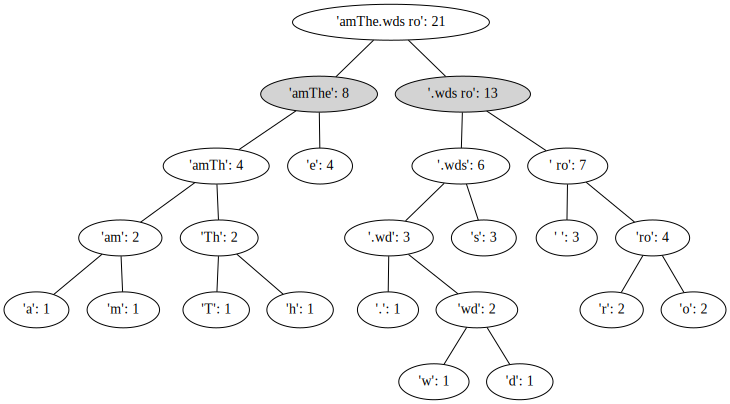

In [8]:
i = 2
while i+1 < len(huff_tree):
    lowest_node, second_lowest_node = huff_tree[i:i+2]
    total_frequency = lowest_node[1] + second_lowest_node[1]
    new_node = (lowest_node[0] + second_lowest_node[0], total_frequency, i)
    
    i += 2
    
    j = i
    while j < len(huff_tree) and huff_tree[j][1] < total_frequency:
        j += 1
    huff_tree.insert(j, new_node)
    display_tree(huff_tree, showchange=True)

Now we have a complete binary tree. To get the binary encodings for each character, we trace the path from the root to the tree, using a string to keep track of the path. We write a '0' to the string if we go to the left child, and we write a '1' for the right child.

I do this using a breadth-first recursion, and I store the binary strings in a dictionary.

In [9]:
def get_binary_strings(tree, encoding_dict, current_node, current_string):
    current_key = current_node[0]
    if len(current_key) == 1:
        encoding_dict[current_key] = current_string
    else:
        left_child = tree[current_node[2]]
        get_binary_strings(tree, encoding_dict, left_child, current_string + '0')
        
        right_child = tree[current_node[2]+1]
        get_binary_strings(tree, encoding_dict, right_child, current_string + '1')

In [10]:
encoding_dict = {}
root = huff_tree[-1]
get_binary_strings(huff_tree, encoding_dict, root, '')

encoding_dict

{'a': '0000',
 'm': '0001',
 'T': '0010',
 'h': '0011',
 'e': '01',
 '.': '1000',
 'w': '10010',
 'd': '10011',
 's': '101',
 ' ': '110',
 'r': '1110',
 'o': '1111'}

To get the binary encoding for our string, we simply replace each character in the string with its binary encoding.

In [11]:
encoded_string = ''.join([encoding_dict[char] for char in some_string])

If we stored the encoded string as binary, it would now take this many bits:

In [12]:
len(encoded_string)

72

Which is less than the number of bits the ascii used.

However, our code is useless without a decoder. To decode the binary, we start at the root of our tree and let each bit of our binary encoding tell us where to go. If the next bit is 0, we go left, and if the next bit is 1 we go right. If we reach a leaf node, we write down its key to another string, go back to the root, and continue. Once we're done, we should have the original string. Here's a demonstration of the process at work:

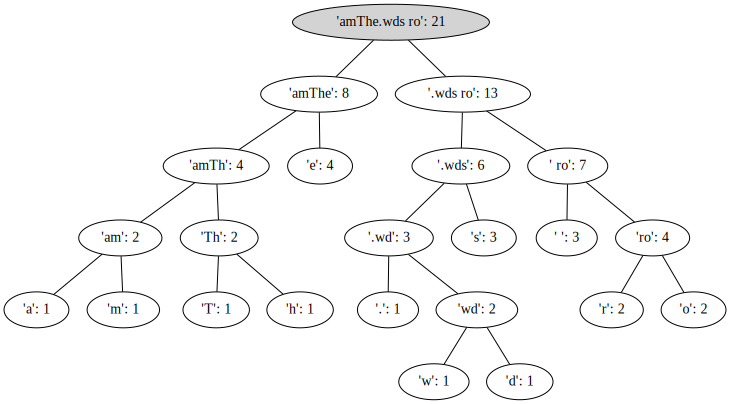

'001000110110101110000011100111010111110001011101001011111110100111011000'

'                                                                       ^'

'These are some words.'

In [13]:
display_decode(huff_tree, encoded_string)

Here's the process written out in code:

In [14]:
def decode(encoded_string, tree):
    decoded_string_list = []
    current_node = root
    
    for bit in encoded_string:
        if bit == '0':
            left_child_position = current_node[2]
            current_node = tree[left_child_position]
        elif bit == '1':
            right_child_position = current_node[2]+1
            current_node = tree[right_child_position]
        key = current_node[0]
        if len(key) == 1:
            decoded_string_list.append(key)
            current_node = root
        
    decoded_string = ''.join(decoded_string_list)
    return decoded_string

In [15]:
decoded_string = decode(encoded_string, huff_tree)
print(decoded_string)

These are some words.


So it seems our encoding really does work!

Todo:
* Use minheap instead of list